## Time Series Analysis: Using ETS and ARIMA

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [2]:
df_airline = pd.read_csv("airline_passengers.csv", index_col="Month")
df_airline.head()

,Thousands of Passengers
Month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [7]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 1949-01 to International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Data columns (total 1 columns):
Thousands of Passengers    144 non-null float64
dtypes: float64(1)
memory usage: 2.3+ KB


In [8]:
df_airline = df_airline.dropna()
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
Thousands of Passengers    144 non-null float64
dtypes: float64(1)
memory usage: 2.2+ KB


In [9]:
# convert the index to datetime index
df_airline.index = pd.to_datetime(df_airline.index)
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [10]:
# create 6 month and 12 month simple moving average
df_airline["6M-SMA"] = df_airline["Thousands of Passengers"].rolling(window=6).mean()
df_airline["12M-SMA"] = df_airline["Thousands of Passengers"].rolling(window=12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
matplotlib.rcParams['figure.figsize'] = (16, 8)

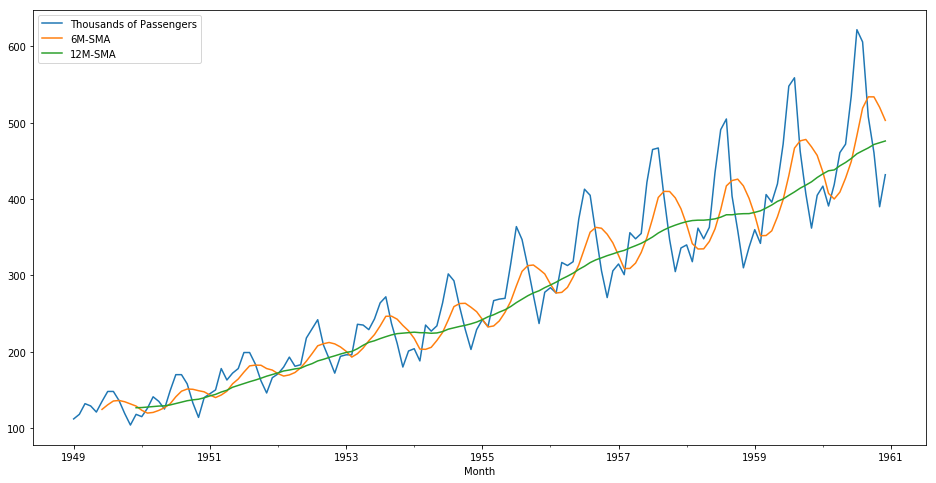

In [13]:
df_airline[["Thousands of Passengers", "6M-SMA", "12M-SMA"]].plot()

In [14]:
# calculating EWMA

df_airline["EWMA"] = df_airline["Thousands of Passengers"].ewm(span=12).mean() 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


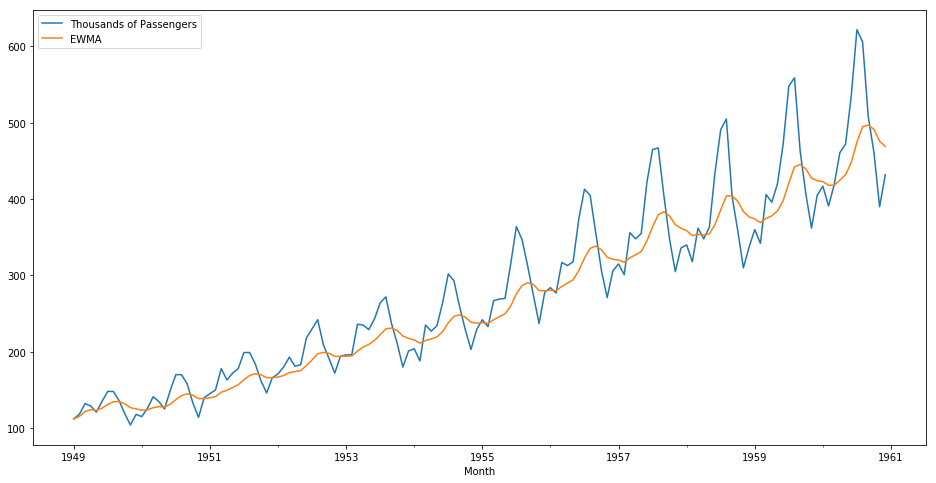

In [15]:
df_airline[["Thousands of Passengers", "EWMA"]].plot()

### Decomposing the error, trend and seasonality (ETS) aspects 

ETS is Error, Trend, and Seasonality. It is a forecasting technique that decomposes times series into following parts:

    Error: Residuals, or noise in the data.
    Trend: The overall structure - whether it is increasing or decreasing.
    Seasonality: Short term recurring patterns
    Level: The average value of the time series

The time series can be of two types:

#### 1. Additive

Where we can represent the time series as:

Time Series = Error + Trend + Seasonality + Level

It has the following characteristics:

    Trend line is linear
    
    The Seasonality has same frequency (width) and amplitude (height)

#### 2. Multiplicative

Where we can represent the time series as:

Time Series = Error * Trend * Seasonality * Level

It's characteristics are:

    Trend line is non linear: exponential, for instance.
    
    The Seasonality has different frequence and amplitude.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# multiplicative because the trend is not really linear
result = seasonal_decompose(df_airline["Thousands of Passengers"], model="multiplicative")

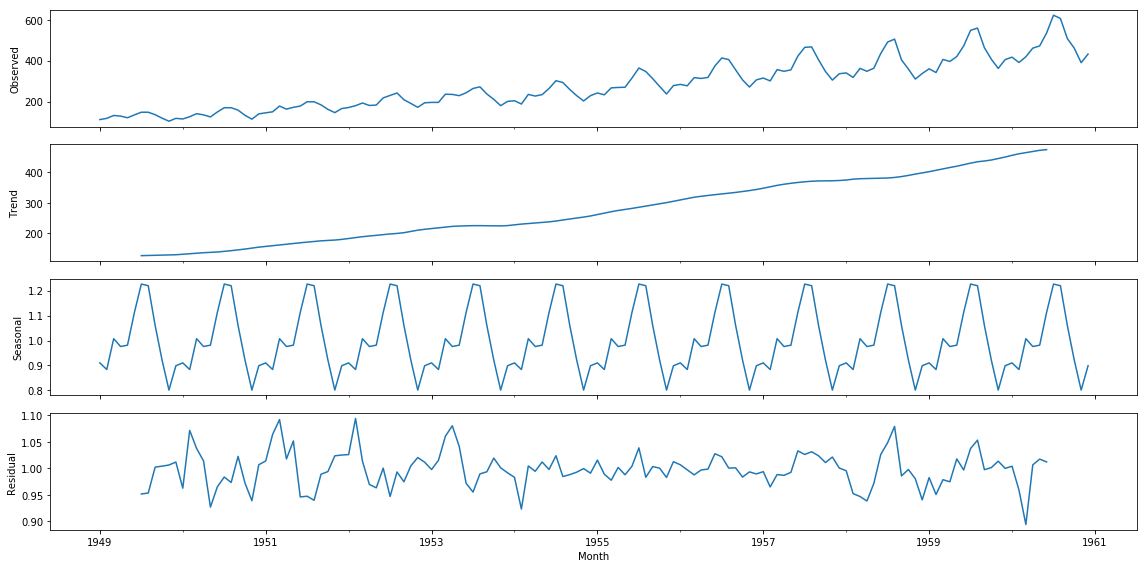

In [17]:
result.plot();

### ARIMA - Auto Regressive Integrated Moving Averages

In [18]:
df_milk = pd.read_csv("monthly-milk-production.csv")
df_milk.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [19]:
# rename columns
df_milk.columns = ["Month", "Milk in Pounds per Cow"]

# drop the last row, it's weird
df_milk = df_milk.drop(168, axis=0)

# Convert index to datetime
df_milk["Month"] = pd.to_datetime(df_milk["Month"])
df_milk.set_index("Month", inplace=True)
df_milk.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


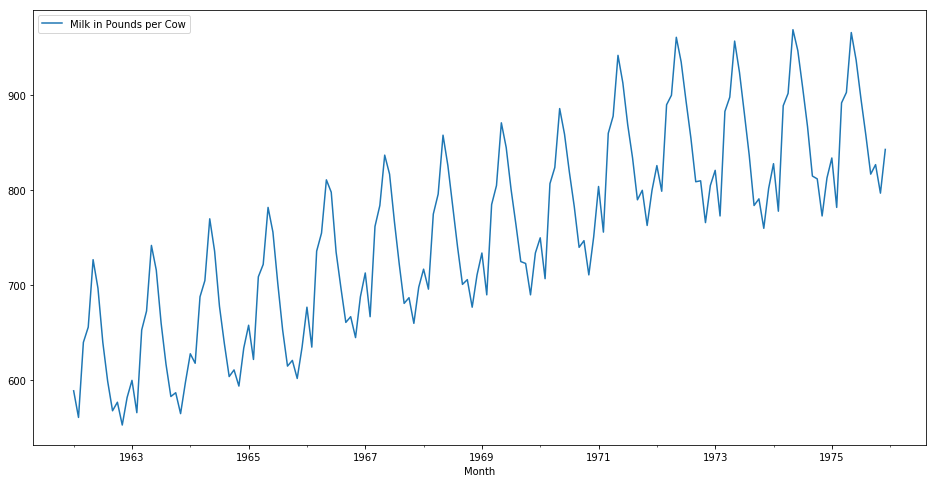

In [20]:
df_milk.plot();

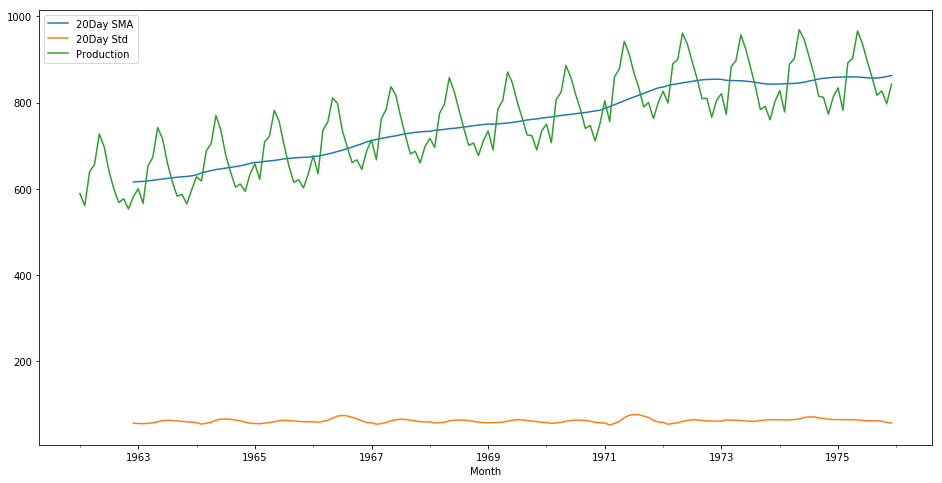

In [21]:
# plotting moving average numbers

df_milk["Milk in Pounds per Cow"].rolling(window=12).mean().plot(label="20Day SMA")
df_milk["Milk in Pounds per Cow"].rolling(window=12).std().plot(label="20Day Std")
df_milk["Milk in Pounds per Cow"].plot(label="Production")
plt.legend();

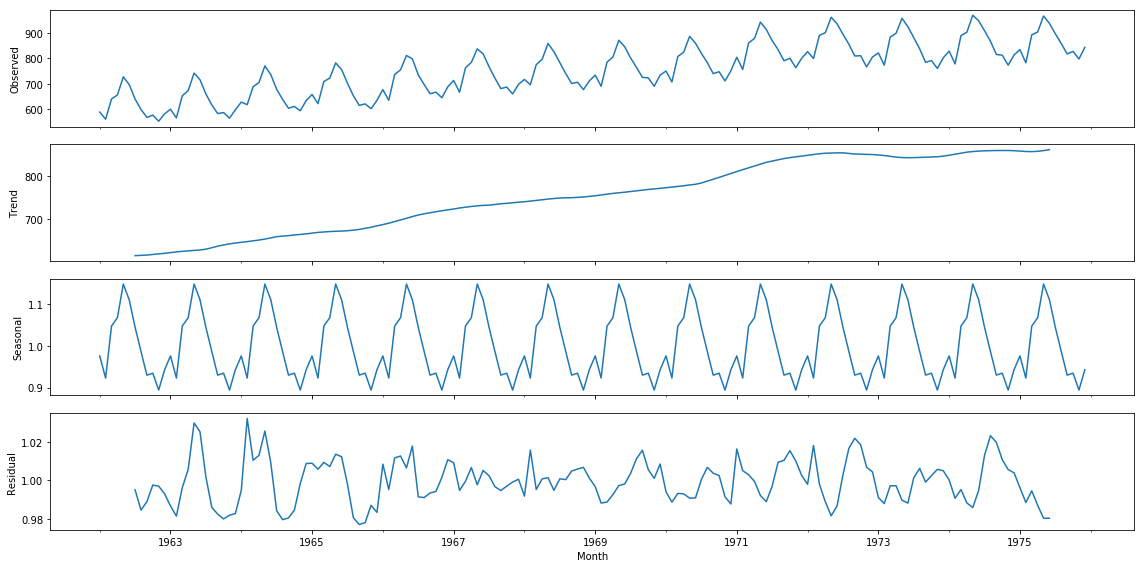

In [22]:
#ETS decomposition
milk_decompose = seasonal_decompose(df_milk["Milk in Pounds per Cow"], model="multiplicative")
milk_decompose.plot();

### Stationarity

A time series is said to be stationary when it's characteristics (mean, variance, covariance) does not change with respect to time.

We can check for stationarity using <b> augmented Dicky-Fuller (ADF) </b> test. This test is based on p-value test. If the p-value turns out to be <= 0.05 then there is strong evidence against null hypothesis. In our case, the null hypothesis is the underlying process is non-stationary. If the p-value is > 0.05 then the process is stationary.

Applying ADF test on the milk production dataset will tell us the nature of the series. We can see visually that the dats is non-stationary, but it is not always possible to extrapolate that visually.

In [23]:
from statsmodels.tsa.stattools import adfuller


def adf_check(tseries):
    result = adfuller(tseries)
    labels = ["ADF test statistic", "P-Value", "Number of lags", "Number of observations used"]
    for value, label in zip(result, labels):
        print("{0}: {1:0.2f}".format(label, value))
    
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Data is non-stationary")

adf_check(df_milk["Milk in Pounds per Cow"])

ADF test statistic: -1.30
P-Value: 0.63
Number of lags: 13.00
Number of observations used: 154.00
Weak evidence against null hypothesis
Data is non-stationary


### AutoCorrelation

Autocorrelation is a characteristic of data when there is a correlation between the same variable (at different time steps). This happens when the underlying data, instead of being random, is chosen from the same source.

It tests for randomness in data. An autocorrelation close to zero means there is no significant pattern, while AC close to 1 means there is a strong pattern. One very important application of autocorrelation is testing random number generators.

Autocorrelation plot: In order to plot autocorrelation, we shift the time series by "x" and then calculate the autocorrelation. Now these "x" values will be plotted on x-axis, and their autocorrelation on y-axis. Initially the autocorrelation will be 1, since shifting the time series by 0 will make the autocorrelation 1, later it will go on decreasing.

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

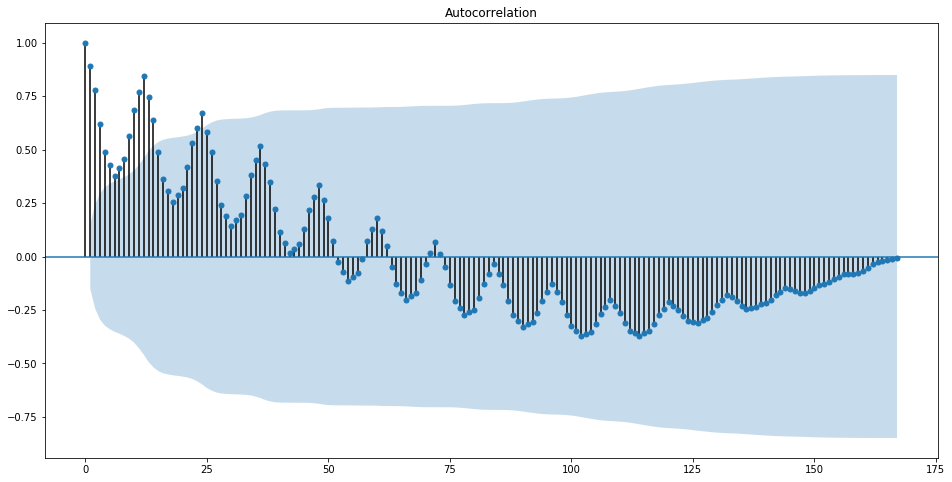

In [25]:
fig = plot_acf(df_milk["Milk in Pounds per Cow"].dropna())

D:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


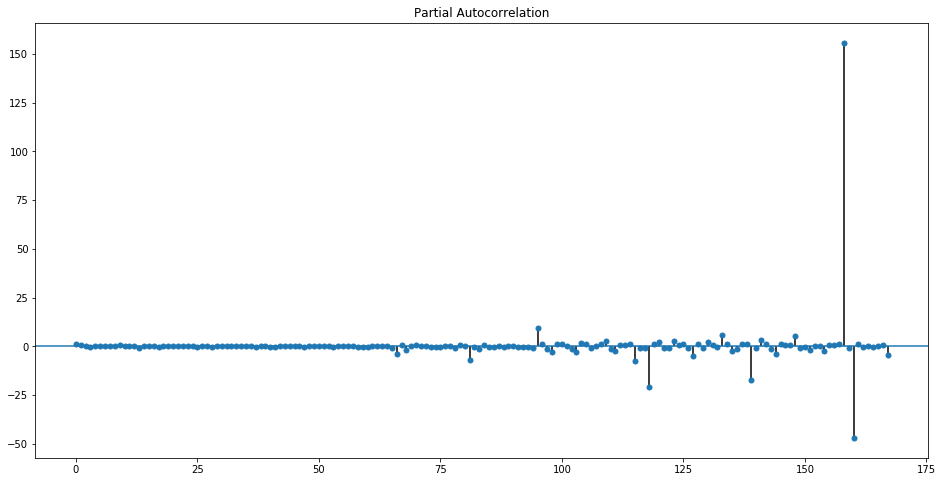

In [26]:
fig = plot_pacf(df_milk["Milk in Pounds per Cow"].dropna())

In [27]:
# since we have seasonal model, we'll be using seasonal ARIMA model

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [37]:
#a detailed help note is available on SARIMAX
help(SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters. `d` must be an integer
 |      indicating the integration order of the process, while
 |      `p` and `q` may either be an integers indicating the AR and MA
 |      orders (so that all lags up to those orders are included) or else
 |      iterables giving specific AR and / or MA lags to include. Default is
 |      an AR(1) model: (1,0,0).
 |  seasonal_order : iterable, optional
 |      The (P,D,Q,s) order of the 

In [30]:
model = SARIMAX(df_milk["Milk in Pounds per Cow"], order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [31]:
results = model.fit()

In [32]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Mon, 11 Jun 2018   AIC                           1074.131
Time:                                    18:55:15   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

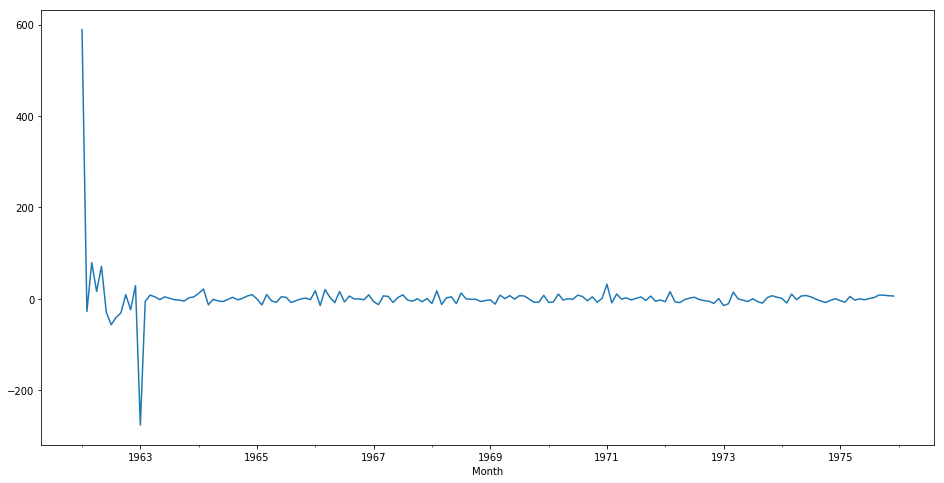

In [33]:
results.resid.plot();

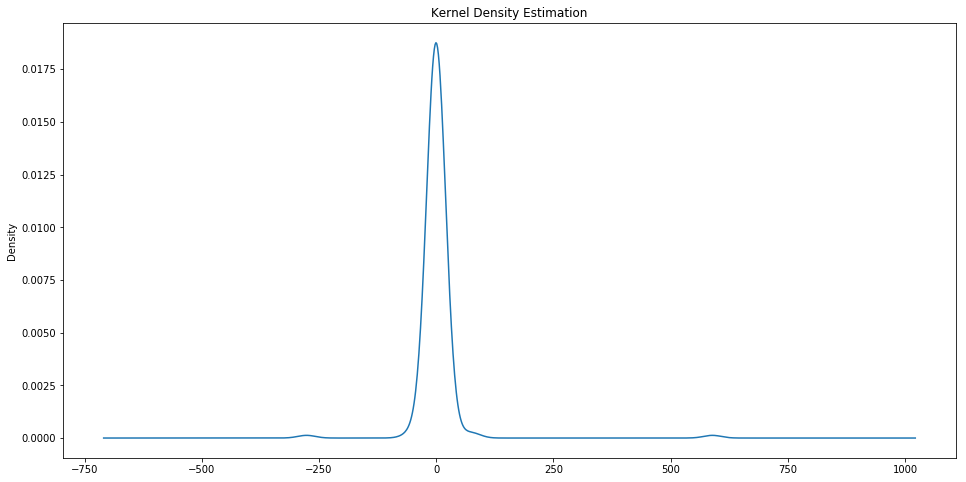

In [34]:
fig = results.resid.plot(kind="KDE")
fig.set_title("Kernel Density Estimation");

In [35]:
#Forecasting values using base trends

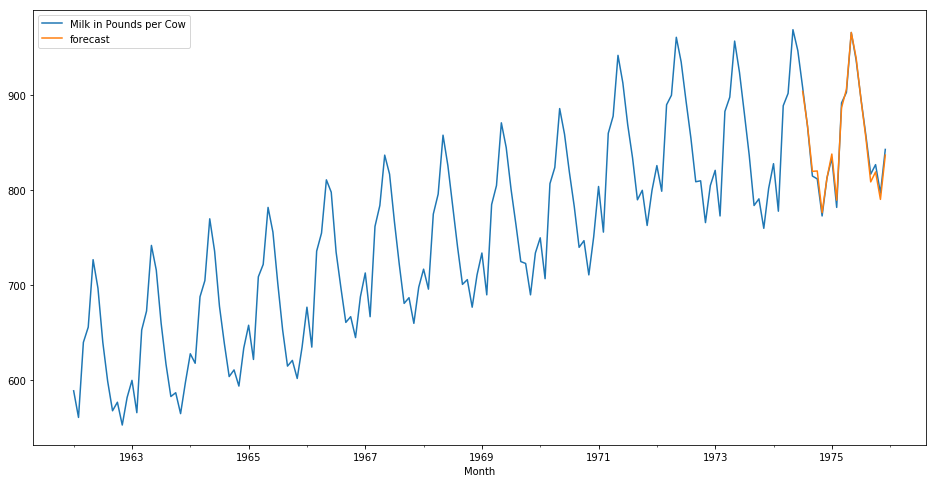

In [36]:
df_milk["forecast"] = results.predict(start=150, end=168)
df_milk[["Milk in Pounds per Cow", "forecast"]].plot();